<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Vamos conduzir uma análise detalhada das Bases de Operação da Loggi no Distrito Federal, com o objetivo de identificar potenciais melhorias que possam elevar a eficiência da operação. Nosso estudo será fundamentado em três pilares: a localização estratégica das bases, o volume de entregas efetuadas e o tamanho médio das encomendas. A partir desses parâmetros, buscamos avaliar a necessidade de manutenções ou ajustes que possam refinar ainda mais o desempenho logístico e garantir a excelência operacional

## 2\. Pacotes e bibliotecas

In [34]:
!pip install geopy
!pip install geopandas
!pip install geobr
!pip install descartes

import pandas as pd
import requests
import seaborn as sns
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

## 3\. Exploração de dados

In [41]:
json_url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'
csv_url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv'
json_file = 'deliveries.json'
csv_file = 'deliveries-geodata.csv'
info_bases = pd.read_json("deliveries.json")
info_entregas = pd.read_csv("deliveries-geodata.csv", header = 0)
info_bases.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


## 4\. Manipulação

In [36]:
info_bases = pd.merge(info_bases, info_entregas, how="inner", left_index=True, right_index=True)
info_bases_normalized = pd.json_normalize(info_bases["origin"])
info_bases = pd.merge(info_bases, info_bases_normalized, how="inner", left_index=True, right_index=True)
info_bases.drop(columns=["origin", "delivery_lat", "delivery_lng"], inplace=True)
info_bases.rename(columns={
    "name": "Nome",
    "region": "Base",
    "vehicle_capacity": "Capacidade_Veiculo",
    "deliveries": "Entregas",
    "lng": "lng_base",
    "lat": "lat_base",
    "delivery_city": "Cidade_entrega",
    "delivery_suburb": "Região_entrega"
}, inplace=True)
info_bases = info_bases[[
    "Nome", "Base", "lng_base", "lat_base", "Cidade_entrega",
    "Região_entrega", "Capacidade_Veiculo", "Entregas"
]]
bases_exploded = info_bases[["Entregas"]].explode("Entregas")
bases_exploded = pd.concat([
    bases_exploded["Entregas"].apply(lambda extrair: extrair["size"]).rename("Tamanho_Entrega"),
    bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lng"]).rename("lng_entrega"),
    bases_exploded["Entregas"].apply(lambda extrair: extrair["point"]["lat"]).rename("lat_entrega"),
], axis=1)
info_bases = pd.merge(info_bases, bases_exploded, how="right", left_index=True, right_index=True)
info_bases.reset_index(drop=True, inplace=True)
info_bases[["Cidade_entrega", "Região_entrega"]] = info_bases[["Cidade_entrega", "Região_entrega"]].fillna("Indisponível")
info_bases.head()


,Nome,Base,lng_base,lat_base,Cidade_entrega,Região_entrega,Capacidade_Veiculo,Tamanho_Entrega,lng_entrega,lat_entrega
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Ceilândia,P Sul,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Ceilândia,P Sul,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Ceilândia,P Sul,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Ceilândia,P Sul,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Ceilândia,P Sul,180,7,-48.114898,-15.858055


## 5\. Visualização

In [37]:
mapa_distrito = geobr.read_municipality(code_muni='DF', year=2020)
geo_base = info_bases[["Base", "lng_base", "lat_base"]].drop_duplicates().reset_index(drop=True)
geo_base_df = gpd.GeoDataFrame(geo_base, geometry=gpd.points_from_xy(geo_base["lng_base"], geo_base["lat_base"]))
geo_entregas_df = gpd.GeoDataFrame(info_bases, geometry=gpd.points_from_xy(info_bases["lng_entrega"], info_bases["lat_entrega"]))
total_entregas = info_bases['Tamanho_Entrega'].sum()
total_entregas_base = (info_bases.groupby('Base')['Tamanho_Entrega']
                       .sum().reset_index()
                       .rename(columns={'Tamanho_Entrega': 'total_base', 'Base': 'região'}))
total_entregas_base['porcentagem_total_entregas'] = (total_entregas_base['total_base'] / total_entregas).round(2)
rank_cidades_entregas = (info_bases['Cidade_entrega'].value_counts()
                         .reset_index()
                         .rename(columns={'index': 'cidade', 'Cidade_entrega': 'qtd_entregas'}))
print(total_entregas_base.head())
print(rank_cidades_entregas.head())

  região  total_base  porcentagem_total_entregas
0   df-0      385932                        0.11
1   df-1     1681582                        0.48
2   df-2     1439010                        0.41
              qtd_entregas   count
0                     Gama  312054
1                Ceilândia  117466
2  Sol Nascente/Pôr do Sol   66571
3       Núcleo Bandeirante   62832
4             Águas Claras   62187


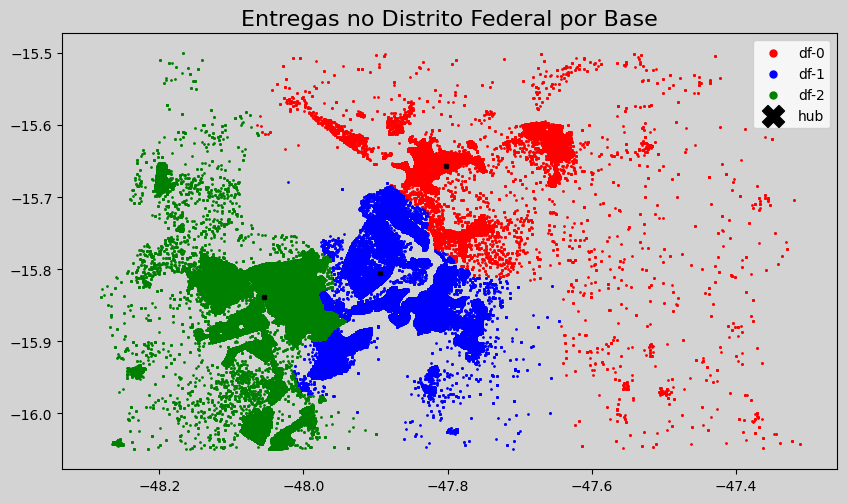

In [42]:
fig_width = 10
fig_height = fig_width / 1.618
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
fig.patch.set_facecolor('lightgray')
ax.set_facecolor('lightgray')
mapa_distrito.plot(ax=ax, alpha=0.4, color="lightgrey")
geo_entregas_df.query("Base == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_entregas_df.query("Base == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_entregas_df.query("Base == 'df-2'").plot(ax=ax, markersize=1, color="green", label="df-2")
geo_base_df.plot(ax=ax, markersize=10, marker="X", color="black", label="hub")
plt.title("Entregas no Distrito Federal por Base", fontsize=16)
lgnd = plt.legend(prop={"size": 10}, markerscale=5, loc="upper right")
plt.show()

1º Insight:

A análise atual demonstra que as bases de operação estão localizadas de maneira estratégica, com uma distribuição que parece atender de forma eficaz às demandas observadas até o momento. No entanto, é crucial considerar a evolução futura das necessidades logísticas. Com a tendência crescente de demanda, pode ser prudente prever um planejamento proativo para a expansão da rede de bases.

Observando o gráfico, nota-se que a maior parte das bases está concentrada na parte central e esquerda da área geográfica analisada. Para otimizar ainda mais o atendimento e a eficiência operacional, seria vantajoso contemplar a abertura de uma nova base na região leste do gráfico. Esta expansão não apenas melhoraria a cobertura geográfica, reduzindo os tempos de entrega e aumentando a eficiência, como também prepararia a operação para um crescimento sustentável a longo prazo.


<ipython-input-39-64490eeac2db>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='muted')
<ipython-input-39-64490eeac2db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='muted')


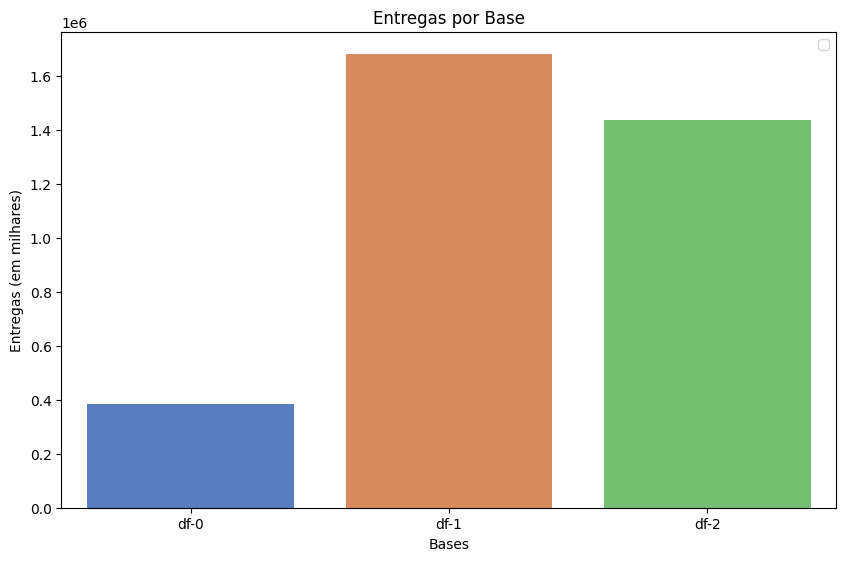

In [39]:
fig_width = 10
fig_height = fig_width / 1.618

fig = plt.figure(figsize=(fig_width, fig_height))
total_entregas_grafico = sns.barplot(data=total_entregas_base, x='região', y='total_base', ci='sd', palette='muted')
total_entregas_grafico.set(title='Entregas por Base', xlabel='Bases', ylabel='Entregas (em milhares)')
lgnd = plt.legend(prop={"size": 10}, markerscale=5, loc="upper right")

plt.show()

2º Insight:

O gráfico apresentado revela claramente as variações na quantidade de entregas entre as diferentes bases de operação. É notável que a Base 0 apresenta um número significativamente menor de entregas em comparação com outras bases. Esta discrepância sugere a necessidade de uma análise mais aprofundada para entender os fatores que contribuíram para essa diminuição.

Dada a importância estratégica das bases na otimização das operações logísticas, é essencial investigar as razões subjacentes à redução nas entregas da Base 0. Questões como mudanças na demanda regional, possíveis problemas operacionais, ou até mesmo alterações nos processos de distribuição devem ser consideradas. Além disso, é prudente avaliar se houve alguma mudança recente na estrutura ou na gestão da base que possa ter impactado seu desempenho.

<ipython-input-40-4e8c8d9b763f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico_tamanho_entregas = sns.boxenplot(x=info_bases["Tamanho_Entrega"], palette='pastel')


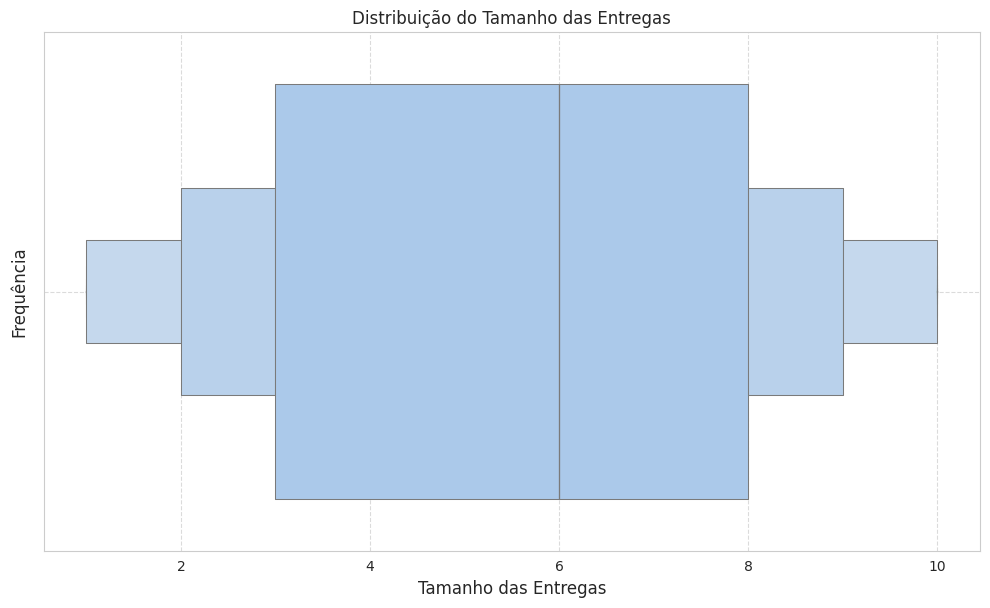

In [40]:
fig_width = 10
fig_height = fig_width / 1.618
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(fig_width, fig_height))
    grafico_tamanho_entregas = sns.boxenplot(x=info_bases["Tamanho_Entrega"], palette='pastel')
    grafico_tamanho_entregas.set(title="Distribuição do Tamanho das Entregas", xlabel="Tamanho das Entregas")
    grafico_tamanho_entregas.set_xlabel("Tamanho das Entregas", fontsize=12)
    grafico_tamanho_entregas.set_ylabel("Frequência", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()

**3º Insight:**

O gráfico de boxenplot fornece uma visão detalhada da distribuição do tamanho das entregas, permitindo uma compreensão clara da quantidade média de pacotes por entrega. Esta análise é crucial, pois oferece insights valiosos sobre a eficiência operacional da empresa e a adequação dos recursos logísticos utilizados.

A partir desses dados, podemos avaliar o funcionamento atual da operação de entrega e identificar se o tamanho médio dos pacotes está alinhado com a capacidade dos caminhões da empresa. Se a análise revelar uma variação significativa no tamanho das entregas, pode ser necessário revisar a configuração dos veículos de transporte para garantir que estejam otimizados para acomodar a carga de forma eficiente.

Além disso, compreender a distribuição dos tamanhos das entregas ajuda a identificar possíveis oportunidades de ajuste, como a necessidade de adquirir caminhões com diferentes capacidades ou ajustar os processos de empacotamento e roteirização. Esse conhecimento permite à empresa adaptar suas operações para melhorar a eficiência logística e reduzir custos associados ao transporte.

Portanto, este insight não apenas fornece uma visão sobre o tamanho dos pacotes, mas também serve como um ponto de partida para otimizar a frota de veículos e os processos logísticos, garantindo que a empresa possa atender às demandas de maneira eficaz e econômica.